<a href="https://colab.research.google.com/github/Aritra153/Semantic_Segmentation_project/blob/main/Segmentation_of_Handwritten_digits_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the required Libraries/Modules
import os
import zipfile

import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split


We know that the MNIST dataset mainly consists of Handwritten digits and it is widely used for various applications of computer vision problems including Classification(where the CNN architecture used for training the model can be of various forms).Here I am using M2NIST, which is a multi-digit MNIST in which each image consists of 3 hand-written digits. Each image also has a corresponding label to it, which contains the Annotation of the image and it is used while training the dataset for Semantic Segmentation. I will be downloading and extracting the dataset from Google Cloud. This dataset is also available in Kaggle.  

In [2]:
# downloading the zipped M2NIST dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip \
    -O /tmp/m2nist.zip

# finding and extracting it to a local folder ('/tmp/training')
local_zip = '/tmp/m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

--2023-07-01 03:50:14--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.128, 142.251.31.128, 142.251.18.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  16.7MB/s    in 1.0s    

2023-07-01 03:50:15 (16.7 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



The folder **combined.npy**(after extraction) contains the images and the folder **segmented.npy** contains the corresponding segmentation masks(or Annotations). Each image is of size (64 x 84),in (height x width) format. The dataset has 5000 image samples and it can be divided appropriately into Training, Cross-Validation and Test sets.
Here I have used **75%** of the**(images,annotations)** as**(training_images,training_annotations)**and **25%** of it as **(Cross-validation images,Cross-validation annotation)**. Further I have used **25%** of the **Cross Validation** sets of **Images and Annotations** as the **Test images and Annotations**.

In [3]:
BATCH_SIZE = 50 #This batch size will be used during training by Mini-Batch Gradient Descent

def read_image_and_annotation(image, annotation):
  '''
  Casts the image and annotation to their expected data type and
  normalizes the input image so that each pixel is in the range [-1, 1]

  Arguments:
    image (numpy array) -- input image
    annotation (numpy array) -- ground truth label map

  Returns:
    preprocessed image-annotation pair
  '''

  image = tf.cast(image, dtype=tf.float32)
  image = tf.reshape(image, (image.shape[0], image.shape[1], 1,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  image = image / 127.5
  image -= 1

  return image, annotation


def get_training_dataset(images, annos):
  '''
  Prepares shuffled batches of the training set.

  Arguments:
    images (list of strings) -- paths to each image file in the train set
    annos (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  training_dataset = training_dataset.map(read_image_and_annotation)

  training_dataset = training_dataset.shuffle(512, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(images, annos):
  '''
  Prepares batches of the validation set.

  Args:
    images (list of strings) -- paths to each image file in the val set
    annos (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  validation_dataset = validation_dataset.map(read_image_and_annotation)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()

  return validation_dataset


def get_test_dataset(images, annos):
  '''
  Prepares batches of the test set.

  Arguments:
    images (list of strings) -- paths to each image file in the test set
    annos (list of strings) -- paths to each label map in the test set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  test_dataset = tf.data.Dataset.from_tensor_slices((images, annos))
  test_dataset = test_dataset.map(read_image_and_annotation)
  test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

  return test_dataset


def load_images_and_segments():
  '''
  Loads the images and segments as numpy arrays from npy files
  and makes splits for training, validation and test datasets.

  Returns:
    3 tuples containing the train, val, and test splits
  '''

  #Loads images and segmentation masks.
  images = np.load('/tmp/training/combined.npy')
  segments = np.load('/tmp/training/segmented.npy')

  #Makes training, validation, test splits from loaded images and segmentation masks.
  train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.25, shuffle=True)
  val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.20, shuffle=True)

  return (train_images, train_annos), (val_images, val_annos), (test_images, test_annos)


Segregation of the Training, Cross-Validation and Testing Datasets using the functions I defined earlier and further separating the images and Annotations in each.

In [4]:
# Loading the Dataset
train_slices, val_slices, test_slices = load_images_and_segments()

# Create training, validation, test datasets.
training_dataset = get_training_dataset(train_slices[0], train_slices[1])
validation_dataset = get_validation_dataset(val_slices[0], val_slices[1])
test_dataset = get_test_dataset(test_slices[0], test_slices[1])

In the cell below, I have assigned a different colour for annotating each of the 11 classes(10 digits and background). I have allocated the colour selection to be random but one may allocate fixed colours of their choice to each class. Also I have shown images and annotations side by side for 10 random images from the Training set and Validation set, and fit them using Subplot.

In [7]:
# Visualization Utilities

# there are 11 classes in the dataset: one class for each digit (0 to 9) plus the background class
n_classes = 11

# assigning a random color for each class
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Arguments:
    images (list of numpy arrays) - numpy array representations of the images to paste

  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]

  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array

  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')

  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps. Also overlays the metrics.

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the ground truth label map
    prediction (numpy array) -- the predicted label map
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each class
  '''

  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]

  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
  '''
  Displays images and its colored annotations side by side

  Arguments:
    dataset (tf Dataset) -- batch of images and annotations
    num_images (int) -- number of images to display
  '''
  ds = dataset.unbatch()

  plt.figure(figsize=(20, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())


<ipython-input-7-9d23156447b4>:136: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


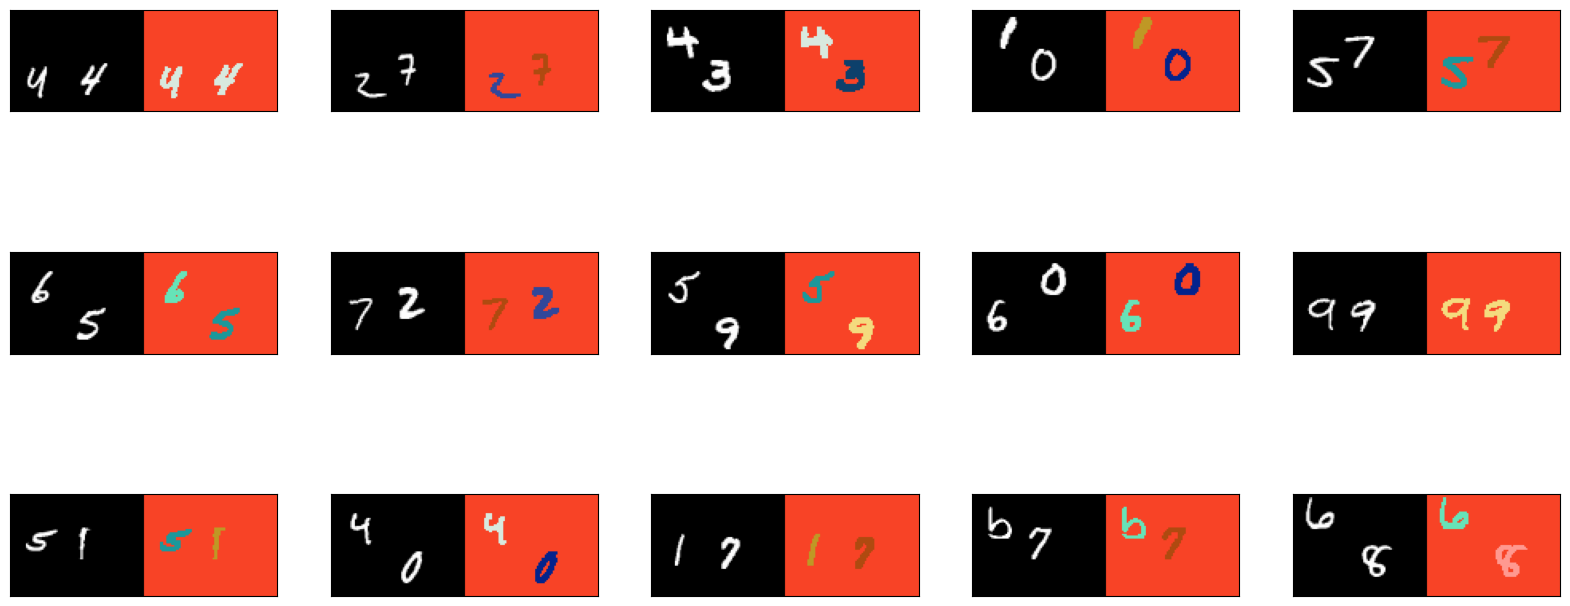

In [8]:
# getting 15 images from the training set and showing their coloured annotation
list_show_annotation(training_dataset, 15)

<ipython-input-7-9d23156447b4>:136: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 5, idx + 1)


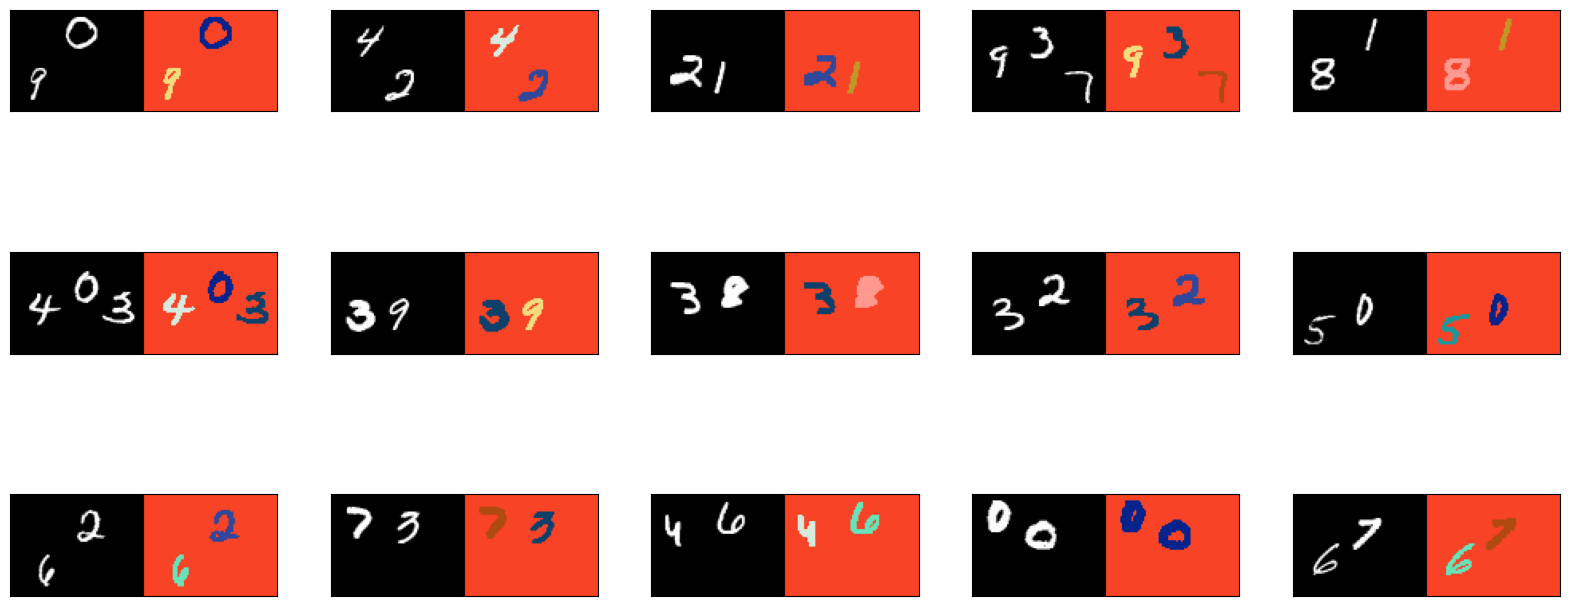

In [9]:
# get 15 images from the validation set and showing their coloured annotation
list_show_annotation(validation_dataset, 15)

The **Encoder** section of the Semantic segmentation is used for extracting features from the image(which is to be segmented) and hence we use a **CNN** for this. The more deeper the CNN is, the more feature it would be able to extract.The use of **ResNet** architecture or say **VGG NET 16** hence would be able to extract more features. Specifically, the VGG NET architecture takes as input images of size (224 x 224), but our input image size is (64 x 84). So I have tried creating a VGG type architecture with **ConV2D** and **MaxPooling** layers. I have modified the architecture a bit. It consists of 5 blocks.The 1st 2 blocks consists of 2 ( Conv2D -> 'LeakyRelu' activation) layers followed by (MaxPooling Layer -> BatchNormalization) layers and the next 3 blocks consists of 3 (Conv2D -> 'LeakyRelu') layers followed by (MaxPooling Layer -> BatchNormalization).

In [10]:
def block_unit(input_img,n_filters,pool_stride,n_blocks,window_size,pool_size):
  '''Input Parameters:-
     input_img:Input Image, a Tensor of shape (image_height,image_width,no.of channels)
     n_fliters:No.of filters used in each Convolution layer(this would also be the no.of channels in the output image)
     pool_stride:stride value in MaxPooling
     n_blocks:no.of segments of Conv2D -> LeakyReLU layers in each block of the encoder.
     window_size:kernel size in Conv2D steps.
   '''
  x=input_img
  for i in range(n_blocks):
    x=tf.keras.layers.Conv2D(filters=n_filters,kernel_size=window_size,padding='same',data_format='channels_last')(x)
    x=tf.keras.layers.LeakyReLU()(x)
  x=tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=pool_stride)(x)
  x=tf.keras.layers.BatchNormalization(axis=-1)(x)

  return x

In [11]:
#Testing Cell:To test whether the block_unit I defined earlier is functioning properly or not
test_input=tf.keras.layers.Input(shape=(64,84,1))
x = tf.keras.layers.ZeroPadding2D(padding = (0, 6), data_format = 'channels_last')(test_input)
y=block_unit(x,32,2,2,3,2)
y1=block_unit(y,64,2,2,3,2)
y2=block_unit(y1,128,2,3,3,2)
y3=block_unit(y2,256,2,3,3,2)
y4=block_unit(y3,256,2,3,3,2)
test_model=tf.keras.Model(inputs=test_input,outputs=y4)

print(test_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 84, 1)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 64, 96, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 64, 96, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 96, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 96, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 96, 32)        0         
                                                             

In [12]:
def Encoder_block(input_height,input_width,n_channels): #Height, Width and no.of channels of Input image

  input_img=tf.keras.layers.Input(shape=(input_height,input_width,n_channels))
  x=tf.keras.layers.ZeroPadding2D(padding = (0, 6), data_format = 'channels_last')(input_img) #Padding the image width to 96 pixels(84+6+6=96)
  x=block_unit(x,32,2,2,3,2)
  E1=x

  x=block_unit(x,64,2,2,3,2)
  E2=x

  x=block_unit(x,128,2,3,3,2)
  E3=x

  x=block_unit(x,256,2,3,3,2)
  E4=x

  x=block_unit(x,256,2,3,3,2)
  E5=x

  return input_img,E1,E2,E3,E4,E5  #The function gives as output the input_img and E1,E2,E3,E4,E5(the ouptputs after each block.)


For the Decoder part, I have used **Fully Convolutional Networks(FCN)** architecture. The FCN architecture uses **Upsampling** and **Transpose Covolution** layers for upscaling of the images back to their original pixel values. There are basically 3 types of FCN architectures:FCN 8's, FCN 16's and FCN 32's. The promptness(or accuracy) of segmentation is most for FCN 8's and it outputs the segmentation almost nearest to the ground truth annotation.Hence it has the highest **IOU** and **Dice Score** for each object classes in the image.
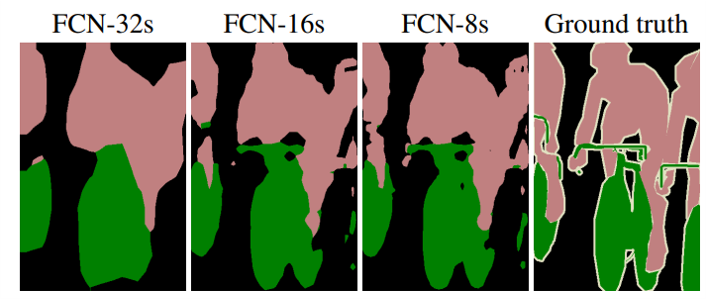


In [13]:
def FCN_8_block(E1,E2,E3,E4,E5,output_classes):

  A=tf.keras.layers.Conv2D(output_classes,  (1, 1), activation='relu' , padding='same', data_format='channels_last')(E5)
  A=tf.keras.layers.Conv2DTranspose(output_classes,kernel_size=(4,4),strides=(2,2),use_bias=False)(A)
  A=tf.keras.layers.Cropping2D(cropping=(1,1))(A)

  B=tf.keras.layers.Conv2D(output_classes,kernel_size=(1,1),padding='same')(E4)
  B=tf.keras.layers.LeakyReLU()(B)
  D1=tf.keras.layers.Add()([A,B])

  D1=tf.keras.layers.Conv2D(output_classes,(1,1),activation='relu',padding='same',data_format='channels_last')(D1)
  D1=tf.keras.layers.Conv2DTranspose(output_classes,kernel_size=(4,4),strides=(2,2))(D1)
  D1=tf.keras.layers.Cropping2D(cropping=(1,1))(D1)

  C=tf.keras.layers.Conv2D(output_classes,kernel_size=(1,1),padding='same')(E3)
  C=tf.keras.layers.LeakyReLU()(C)
  D2=tf.keras.layers.Add()([D1,C])

  D2=tf.keras.layers.Conv2DTranspose(output_classes,kernel_size=(8,8),strides=(8,8))(D2)
  D2=tf.keras.layers.Cropping2D(cropping=((0,0),(0,96-84)))(D2) # Cropping here resizes the image back to its original input dimension(64 x 84)
  D2=(tf.keras.layers.Activation('softmax'))(D2)

  return D2

Now I have combined the Encoder(or Downsampling) and Decoder(or Up-Sampling) section together by 'Model' functionality of Tensorflow with the input image size as an input and the final processed image(or segmented image) as an output.

In [14]:
Input_size=(64,84,1) # as the M2NIST images are black & white in colour, the no.of colour channels in 1 and not 3(which is in general for a coloured image)
num_output_classes=11 #There are 11 output classes (10 digits + background)
input_img,E1,E2,E3,E4,E5=Encoder_block(64,84,1)
Output_size=FCN_8_block(E1,E2,E3,E4,E5,num_output_classes)
segmentation_model=tf.keras.Model(inputs=input_img,outputs=Output_size)

In [15]:
segmentation_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 84, 1)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 64, 96, 1)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 96, 32)   320         ['zero_padding2d_1[0][0]']       
                                                                                                  
 leaky_re_lu_13 (LeakyReLU)     (None, 64, 96, 32)   0           ['conv2d_13[0][0]']        

I will be using **Adam optimizer** for training the segmentation_model .

In [16]:
sgd=tf.keras.optimizers.Adam(learning_rate=0.05,beta_1=0.9,beta_2=0.999,epsilon=1e-05)
segmentation_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

I will train the model now. I have taken the number of **Epochs** to be 80. The batch size is 50(denoted by **BATCH_SIZE** ) as already set earlier.As the no.of training images is 75% of the total no.of images, so n_training_images=3750. So leftover 25%, that is 1250 are Cross-validation images + Test image. Now the no.of Test images is 20% of the 1250, i.e. 250.Hence n_test_images=250. The no.of Cross Validation images is hence 1000 i.e. n_validation_images=1000

In [17]:
Epochs=80
n_training_images=3750
n_validation_images=1000
n_test_images=250

STEP_PER_EPOCH=3750//BATCH_SIZE
NUM_VALIDATION_STEPS=1000//BATCH_SIZE
NUM_TEST_STEPS=250//BATCH_SIZE

history = segmentation_model.fit(training_dataset, steps_per_epoch=STEP_PER_EPOCH, validation_data=validation_dataset, validation_steps=NUM_VALIDATION_STEPS, epochs=Epochs)

Epoch 1/80
75/75 [==============================] - 355s 5s/step - loss: 0.3092 - accuracy: 0.9243 - val_loss: 1.5520 - val_accuracy: 0.9122
Epoch 2/80
75/75 [==============================] - 363s 5s/step - loss: 0.1765 - accuracy: 0.9445 - val_loss: 0.2112 - val_accuracy: 0.9435
Epoch 3/80
75/75 [==============================] - 370s 5s/step - loss: 0.1426 - accuracy: 0.9509 - val_loss: 0.4153 - val_accuracy: 0.9388
Epoch 4/80
75/75 [==============================] - 377s 5s/step - loss: 0.1098 - accuracy: 0.9602 - val_loss: 0.3213 - val_accuracy: 0.9411
Epoch 5/80
75/75 [==============================] - 389s 5s/step - loss: 0.0888 - accuracy: 0.9674 - val_loss: 0.1848 - val_accuracy: 0.9487
Epoch 6/80
75/75 [==============================] - 378s 5s/step - loss: 0.0750 - accuracy: 0.9721 - val_loss: 0.1704 - val_accuracy: 0.9514
Epoch 7/80
75/75 [==============================] - 374s 5s/step - loss: 0.0665 - accuracy: 0.9750 - val_loss: 0.0933 - val_accuracy: 0.9661
Epoch 8/80
75

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

#saving_path='/content/gdrive/My Drive/Model_from_Google_Colab'
segmentation_model.save('/content/gdrive/My Drive/Model_from_Google_Colab/my_segmentation_model.h5')
#saved_segemntation_model = tf.keras.models.load_model('my_segmentation_model.h5')

Mounted at /content/gdrive


In [19]:
'''segmentation_model.save('my_segmentation_model.h5')
from google.colab import files
files.download("my_segmentation_model.h5")'''

'segmentation_model.save(\'my_segmentation_model.h5\')\nfrom google.colab import files\nfiles.download("my_segmentation_model.h5")'

Now I am applying the above model in predicting the segmentation outputs of the Test Images(in Test Dataset). There are 250 test images and the shape of each image must be (64 x 84 x 11). The outputs i.e. the annotations/segmented images should match the dimensions of the input images for each image in the test set. Hence the output(or **output_result** as described below) must have a shape of (250 x 64 x 84 x 11).

In [20]:
output_result = segmentation_model.predict(test_dataset, steps=NUM_TEST_STEPS)

5/5 [==============================] - 6s 977ms/step


In [21]:
print(output_result.shape)

(250, 64, 84, 11)


Each pixel corresponding to each of the images in the **output_result** above, is basically the output of a **'Softmax'** activation function corresponding to 11 classes. Hence each pixel will give 11 probabilty values as outputs. The class corresponding to the maximum probabilty output will be the output class predicted by that pixel.In the cell below I am testing the outputs of some of the pixels of a few images of the test_dataset.

In [22]:
print(output_result[0,0,0,5]) #Probabilty that the class predicted by the top-left most pixel of the 1st image in the test_dataset belongs to class 5(or 6th category)

2.7994602e-06


In [23]:
print(output_result[2,63,0,2]) #Probabilty that the class predicted by the bottom-left most pixel of the 3rd image(as index is 2) in the test_dataset belongs to class 2(or 3rd category)

1.1290246e-08


To get the output class corresponding to each pixel, we need to find that the maximum probabilty output of the pixel corresponds to which class. I have used **np.argmax(axis=3)** (as axis=3 corresponds to the output class axis of a particular pixel) function to get this maximum probability value for each pixels of every output segmented image for the images of the test_dataset. The output_result_pred_class below should contain the image outputs of all the images in the test_dataset, denoting only the class corresponding to the maximum probabilty for each pixel. Hence this should be my required segmented image outputs for every image in the test_dataset.

In [24]:
output_result_pred_class=np.argmax(output_result,axis=3)

In [25]:
print(output_result_pred_class.shape)

(250, 64, 84)


In [26]:
print(output_result_pred_class[99,0,0]) # This should give as output the class predicted by the top left-most pixel of the 100th image(as index is 99) of the test_dataset.
                                        # As we can see in the training and Validation dataset segmented outputs, it should be the 'background'.

10


In [27]:
print(output_result_pred_class[99,:,:]) #The output of this array should be a (64 x 84) dimensional 2-D array, with each pixel in the array showing the predicted class(or class with maximum Softmax probabilty)

[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


To evaluate the performance of my segmentated outputs, I will be using 2 evaluation Metrics : the **IOU value** and the **Dice Score**. The IOU value is given by the general expression :-

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$

and the Dice Score is given by the general expression:-

$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

In simple terms if we take a particular object class for example,
***area_of_overlap*** = number of pixels that corresponds to both the actual annotated image AND predicted annotated image for that object class,
***area_of_Union*** = no.of pixels that corresponds to that object class in the actual annotated image + no.of pixels that corresponds to that object class in the predicted output_image - number of pixels that corresponds to both the actual annotated image AND predicted annotated image for that object class, ***combined_area*** = area_of_Union + area_of_overlap.

In [28]:
def Object_class_wise_metrics(y_true, y_predicted):
  '''
   Arguments:
    y_true (tensor) - ground truth(or actual) label maps
    y_predicted (tensor) - predicted(output) label maps
  '''
  Object_class_iou = []
  Object_class_dice_score = []
  num_classes=11
  correction_factor = 0.00001  # I have added this correction factor so that if somewhere the denominator terms of the IOU and DiceScore values becomes 0, no problem occurs.

  for i in range(num_classes):
    intersection = np.sum((y_predicted == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_predicted_area = np.sum((y_predicted == i))
    combined_area = y_true_area + y_predicted_area
    iou = (intersection) / (combined_area - intersection + correction_factor)
    Object_class_iou.append(iou)
    dice_score =  2 * ((intersection) / (combined_area + correction_factor))
    Object_class_dice_score.append(dice_score)

  return Object_class_iou, Object_class_dice_score


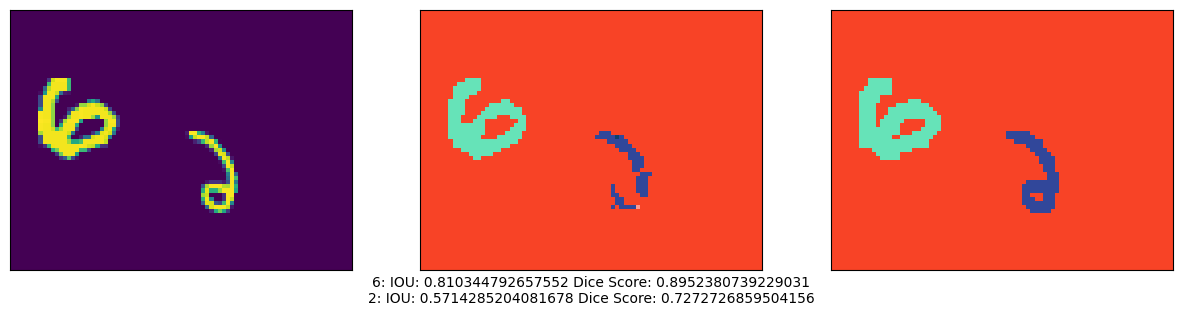

In [29]:
image_number = 200
ds = test_dataset.unbatch()
ds = ds.batch(250)
images = []
y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image
iou, dice_score = Object_class_wise_metrics(np.argmax(y_true_segments[image_number], axis=2), output_result_pred_class[image_number])
show_annotation_and_prediction(image[image_number], annotation[image_number], output_result_pred_class[image_number], iou, dice_score)


In [30]:
cls_wise_iou, cls_wise_dice_score = Object_class_wise_metrics(np.argmax(y_true_segments, axis=3), output_result_pred_class)

average_iou = 0.0
average_DiceScore=0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score))
  average_iou = average_iou+iou
  average_DiceScore= average_DiceScore+dice_score

Digit 0: IOU: 0.7767148594665563 Dice Score: 0.8743269696069953
Digit 1: IOU: 0.7964601753129791 Dice Score: 0.8866995063491678
Digit 2: IOU: 0.7666484409331346 Dice Score: 0.8679128491780683
Digit 3: IOU: 0.7403260088726775 Dice Score: 0.8507900302567275
Digit 4: IOU: 0.7443037963599348 Dice Score: 0.8534107394745917
Digit 5: IOU: 0.719630413935731 Dice Score: 0.836959393255563
Digit 6: IOU: 0.7765899115710985 Dice Score: 0.8742478008155903
Digit 7: IOU: 0.8170934477141188 Dice Score: 0.8993411414718514
Digit 8: IOU: 0.7045324800724598 Dice Score: 0.8266577355481194
Digit 9: IOU: 0.732518400719613 Dice Score: 0.8456111062547522


In [31]:
print(average_iou)

7.574817934958303


In [34]:
print(average_DiceScore)

8.615957272211427
